In [1]:
import numpy as np
import os
import dill as pickle
import matplotlib.pyplot as plt
import pandas as pd
import sys
import hardware_control.wx_programs as wx
import hardware_control.bnc as bnc
from classes.generator import *
from hardware_control.hardware_config import *
from experiment_configuration.values import *
from classes.qubit_class import *
import daq.daq_programs_homo as daq
import classifiers.classifier as classifier
import seaborn as sns
import standard_sequences.rabi_tomo as tomo
import analysis.analysis as analysis
import time
import traceback

In [2]:

q1 = Qubit(q1_dict, readout_dict)
q2 = Qubit(q2_dict, readout_dict)
readout = Readout(readout_dict)
print(f"{q1}\n{q2}")

wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"
bnc.set_bnc_output(
    general_vals_dict["qubit_bnc"], power_dBm=13, bnc_addr=target_bnc_address_6
)
bnc.set_bnc_output(
    readout_dict["RO_LO"],
    power_dBm=readout_dict["RO_LO_pwr"],
    bnc_addr=bnc_address["target_bnc_black"],
)
# bnc.set_bnc_output(
#     general_vals_dict["TWPA_freq"],
#     general_vals_dict["TWPA_pwr"],
#     bnc_addr=bnc_address["big_agilent"],
# )

Qubit(ro_amp=0.35, ef_ssm=-0.2568, ro_freq=6.72739, ge_ssm=-0.1144, ro_dur=5000, ROIF=0.10268999999999995, qubit_id=q1, mixer_offset_ef=6, ef_half_time=25, RO_LO=6.6247, mixer_offset_ge=2.5, RO_LO_pwr=16, ef_amp=1.49, ge_time=77, RO_IF=None, ge_amp=1.01, qubit_thr=[-10000, -600], ef_time=44, ef_half_amp_x=1.31, IQ_angle=60, ef_half_amp_y=1.31)
Qubit(ro_amp=0.5, ef_ssm=-0.2962, ro_freq=6.65554, ge_ssm=-0.154, ro_dur=5000, ROIF=0.030840000000000423, qubit_id=q2, mixer_offset_ef=None, ef_half_time=None, RO_LO=6.6247, mixer_offset_ge=None, RO_LO_pwr=16, ef_amp=1, ge_time=74, RO_IF=None, ge_amp=0.8, qubit_thr=[-10000, 1900], ef_time=None, ef_half_amp_x=None, IQ_angle=25, ef_half_amp_y=None)


In [3]:
def run_rabi_tomo(
    q1,
    q2,
    general_vals_dict,
    num_steps: int,
    sweep_time: float,
    swap_freq: float,
    swap_time: float,
    reps: int,
    tomography: str,
    phase:float,
):
    """
    Runs a single instance of the nonhermitian ef Rabi experiment (with an e-swap to Q2)
    and processes the resulting IQ data to compute probabilities vs. time.

    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    # Run the experiment
    tomo.rabi_ef_swap_tomo(
        q1,
        q2,
        general_vals_dict,
        num_steps=num_steps,
        sweep_time=sweep_time,
        swap_freq=swap_freq,
        swap_time=swap_time,
        drive_amp_J=0,
        tomo_comp=tomography,
        phase=phase,
    )

    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=False
    )

    # Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0]
    Q1_raw = values.rec_readout_1[1]
    I2_raw = values.rec_readout_2[0]
    Q2_raw = values.rec_readout_2[1]

    # Build a DataFrame from the IQ data for classification
    IQ_df = pd.DataFrame({"I1": I1_raw, "Q1": Q1_raw, "I2": I2_raw, "Q2": Q2_raw})

    # Classify the IQ data (classifier.classify returns a DataFrame that has a 'predicted' column)
    classified = classifier.classify(IQ_df)
    states = classified["predicted"]
    # Reshape the predicted states.
    # (Assume that classifier.reshape_for_exp returns an array of shape (num_steps, reps),
    #  where each row corresponds to a time step and holds all the state measurements for that step.)
    states_reshaped = classifier.reshape_for_exp(states, reps, num_steps)
    probabilties = classifier.probabilities(states_reshaped)
    population = classifier.population(states_reshaped)

    # Compute time values as the index for the DataFrame.
    times = np.linspace(0, sweep_time / 1000, num_steps)

    # Build a DataFrame that holds the probability vs. time.
    df_prob = pd.DataFrame(
        {
            "time": times,
            "P_f": probabilties["P_f"],
            "P_e": probabilties["P_e"],
            "P_g": probabilties["P_g"],
        },
        index=times,
    )

    df_pop = pd.DataFrame(
        {
            "time": times,
            "Pop_f": population["Pop_f"],
            "Pop_e": population["Pop_e"],
            "Pop_g": population["Pop_g"],
        },
        index=times,
    )

    return df_prob, df_pop, values

def get_amp_from_filename(filename):
    # Assumes filename format "amp={value}.pkl"
    base = os.path.basename(filename)
    base_no_ext = os.path.splitext(base)[0]  # e.g., "amp=1.23456"
    try:
        amp_str = base_no_ext.split('=')[1]
        return float(amp_str)
    except (IndexError, ValueError):
        return None

In [4]:
def run_amp_measurements():
    # Parameters
    reps = 2000
    sweep_time = 250
    swap_freq = -0.0194
    swap_time = 0.5 * 7 / abs(swap_freq)
    
    num_steps = 51
    sweep_start = 1.34
    sweep_end = 1.36
    sweep_steps = 21
    sweep_vals = np.linspace(sweep_start, sweep_end, sweep_steps)

    # Define folders for plus and minus data (adjust folder names as needed)
    
    tomo_y_folder = os.path.join("sweep_y_tomo", "amp_sweep")
    
    os.makedirs(tomo_y_folder, exist_ok=True)
    # Dictionaries to store the loaded or computed data
       # for tomography "x" measurements
    return_y = {}   # for tomography "y" measurements

    # Optionally, if you want to keep track of the data in lists/arrays:
    sweep_data_x = {}
    sweep_data_y = {}

    # Loop over sweep values (e.g., different amplitude values)
    for i, sweep_val in enumerate(sweep_vals):
        # Build filenames using the sweep value as part of the name
        
        y_filename = os.path.join(tomo_y_folder, f"amp={sweep_val:.5f}.pkl")
        
        # If both files exist, load them and store in the dictionaries
        if  os.path.exists(y_filename):

            with open(y_filename, "rb") as f:
                y_data = pickle.load(f)
        
            return_y[sweep_val] = y_data
            continue  # Skip to the next sweep value if files exist

        # Otherwise, perform the measurement:
        q1.ef_half_amp_y = sweep_val  # Set the current amplitude for the measurement       
        
        tomography_y = "y"
        
        df_prob_y, df_pop_y, values_y = run_rabi_tomo(
            q1,
            q2,
            general_vals_dict,
            num_steps=num_steps,
            sweep_time=sweep_time,
            swap_freq=swap_freq,
            swap_time=swap_time,
            reps=reps,
            tomography=tomography_y    
        )
        
        # Save the measurement results to their respective pickle files
        
        with open(y_filename, "wb") as f:
            pickle.dump(df_prob_y, f)
        
        # Populate the dictionaries with the results, keyed by the amplitude value
        
        return_y[sweep_val] = df_prob_y

    print("Measurement complete!")
    return  return_y
    

In [5]:
def plot_amp_sweep():
    """
    Loads tomo_y pickle files from "amp_sweep/y", computes normalized P_f and
    the standard deviation of (normalized_P_f - p0) for each amplitude.
    Plots a 2D pcolormesh of normalized P_f versus time and amplitude,
    and a line plot of amplitude versus standard deviation with the best amplitude marked.
    """
    # Folder where the tomo_y pickle files are stored
    tomo_y_folder = os.path.join("sweep_y_tomo", "amp_sweep")
    
    # Get a sorted list of pickle files based on the amplitude value
    y_files = sorted(
        [os.path.join(tomo_y_folder, f) for f in os.listdir(tomo_y_folder) if f.endswith('.pkl')],
        key=get_amp_from_filename
    )
    
    # Initialization
    time_array = None  # Will be taken from the first file that contains time values.
    amps_y = []
    norm_Pf_y_list = []       # For the 2D plot of normalized P_f.
    std_deviation_y = []      # For storing the std of (normalized_P_f - p0) per file.
    delta_Pf_time_series = [] # Optional: to store the delta time series.
    
    # Loop through each tomo_y file (each corresponding to a different amplitude)
    for file in y_files:
        amp = get_amp_from_filename(file)
        if amp is None:
            continue
        amps_y.append(amp)
        
        with open(file, "rb") as f:
            df = pickle.load(f)
        
        # Get the time axis (assumed identical for all files)
        if time_array is None:
            if "time" in df.columns:
                time_array = df["time"].values
            else:
                time_array = df.index.values
        
        # Compute normalized P_f: normalized_P_f = P_f / (P_f + P_e)
        df["normalized_P_f"] = df["P_f"] / (df["P_f"] + df["P_e"])
        norm_Pf_y_list.append(df["normalized_P_f"].values)
        
        # Compute p0 as the average of the maximum and minimum values of normalized_P_f
        p0 = (df["normalized_P_f"].max() + df["normalized_P_f"].min()) / 2.0
        
        # Compute delta = normalized_P_f - p0
        delta = df["normalized_P_f"] - p0
        
        # Compute the standard deviation of delta over time
        std_val = delta.std()
        std_deviation_y.append(std_val)
        
        # Save the delta time series for possible later 2D plotting
        delta_Pf_time_series.append(delta.values)
    
    # Convert lists to numpy arrays
    amps_y = np.array(amps_y)
    norm_Pf_y = np.array(norm_Pf_y_list)  # Shape: (number of amplitudes, number of time points)
    std_deviation_y = np.array(std_deviation_y)
    delta_Pf_array = np.array(delta_Pf_time_series)
    
    # Sort data by amplitude for consistent plotting
    sort_idx = np.argsort(amps_y)
    amps_y_sorted = amps_y[sort_idx]
    norm_Pf_y_sorted = norm_Pf_y[sort_idx, :]
    std_deviation_y_sorted = std_deviation_y[sort_idx]
    delta_Pf_array_sorted = delta_Pf_array[sort_idx, :]
    
    # Check that time_array was set properly
    if time_array is None:
        raise ValueError("time_array was not set! Check your pickle files to ensure they contain time data.")
    
    # --- Plot 1: 2D plot of normalized P_f versus time and amplitude ---
    plt.figure(figsize=(8, 6))
    # pcolormesh expects:
    #   X: 1D array for column coordinates (here, time_array)
    #   Y: 1D array for row coordinates (here, amps_y_sorted)
    #   Z: 2D array with shape (len(amps_y_sorted), len(time_array))
    plt.pcolormesh(time_array, amps_y_sorted, norm_Pf_y_sorted, shading='auto')
    plt.colorbar(label='Normalized $P_f$')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title('2D Plot of Normalized $P_f$ (tomo_y)')
    plt.show()
    
    # --- Plot 2: Amp vs Standard Deviation of (Normalized_P_f - p0) ---
    plt.figure(figsize=(8, 6))
    plt.plot(amps_y_sorted, std_deviation_y_sorted, marker='o', linestyle='-')
    plt.xlabel('Amplitude')
    plt.ylabel('Std of (Normalized $P_f$ - p0)')
    plt.title('Amp vs Standard Deviation of (Normalized $P_f$ - p0)')
    plt.grid(True)
    
    # Find the amplitude with the lowest standard deviation (lowest peak)
    min_idx = np.argmin(std_deviation_y_sorted)
    best_amp = amps_y_sorted[min_idx]
    plt.axvline(best_amp, color='red', linestyle='--', label=f'Lowest at amp={best_amp:.5f}')
    plt.legend()
    plt.show()
    
    print("Amplitude with lowest standard deviation:", best_amp)

def plot_tomo_y_amp(amp:float):
    tomo_y_folder = os.path.join("sweep_y_tomo", "amp_sweep")
    y_files = sorted(
        [os.path.join(tomo_y_folder, f) for f in os.listdir(tomo_y_folder) if f.endswith('.pkl')],
        key=get_amp_from_filename
    )

    # --- (Optional) You might already have these from your earlier analysis ---
    # amps_y, std_deviation_y, etc. For this example, we assume you have computed best_amp:
    # For instance, if you already computed:
    # best_amp = amps_y_sorted[np.argmin(std_deviation_y_sorted)]
    # Otherwise, you can set chosen_amp manually:
    chosen_amp = amp #or use: chosen_amp = best_amp

    # --- Find the File Closest to the Chosen Amplitude ---
    closest_file = None
    min_diff = np.inf
    for file in y_files:
        amp_val = get_amp_from_filename(file)
        if amp_val is None:
            continue
        diff = abs(amp_val - chosen_amp)
        if diff < min_diff:
            min_diff = diff
            closest_file = file

    if closest_file is None:
        print("No file found for the chosen amplitude.")
    else:
        print(f"Using file: {closest_file} (amp ~ {get_amp_from_filename(closest_file):.5f})")
        
        # --- Load the Data ---
        with open(closest_file, "rb") as f:
            df = pickle.load(f)
        
        # --- Compute Normalized P_f ---
        # (Assuming df has columns "P_f", "P_e", and either a "time" column or uses the index as time)
        df["normalized_P_f"] = df["P_f"] / (df["P_f"] + df["P_e"])
        
        # --- Plot Normalized P_f vs Time ---
        # Use the 'time' column if available; otherwise, use the index.
        if "time" in df.columns:
            time_axis = df["time"].values
        else:
            time_axis = df.index.values

        plt.figure(figsize=(8,6))
        plt.plot(time_axis, df["normalized_P_f"], marker='o', linestyle='-')
        plt.ylim(0,1)
        plt.xlabel('Time')
        plt.ylabel('Normalized $P_f$')
        plt.title(f'Normalized $P_f$ vs Time at Amp ~ {get_amp_from_filename(closest_file):.5f}')
        plt.grid(True)
        plt.show()


In [6]:
def run_freq_measurements():
    # Parameters
    reps = 4000
    sweep_time = 250
    swap_freq = -0.0194
    swap_time = 0.5 * 7 / abs(swap_freq)
    num_steps = 51
    sweep_start = -.2586
    sweep_end = -.2590
    sweep_steps = 5
    sweep_vals = np.linspace(sweep_start, sweep_end, sweep_steps)

    # Define folders for plus and minus data (adjust folder names as needed)
    
    tomo_y_folder = os.path.join("sweep_y_tomo", "freq_sweep")
    
    os.makedirs(tomo_y_folder, exist_ok=True)
    # Dictionaries to store the loaded or computed data
       # for tomography "x" measurements
    return_y = {}   # for tomography "y" measurements


    # Loop over sweep values (e.g., different amplitude values)
    for i, sweep_val in enumerate(sweep_vals):
        # Build filenames using the sweep value as part of the name
        
        y_filename = os.path.join(tomo_y_folder, f"amp={sweep_val:.5f}.pkl")
        
        # If both files exist, load them and store in the dictionaries
        if  os.path.exists(y_filename):

            with open(y_filename, "rb") as f:
                y_data = pickle.load(f)
        
            return_y[sweep_val] = y_data
            continue  # Skip to the next sweep value if files exist

        # Otherwise, perform the measurement:
        q1.ef_ssm = sweep_val  # Set the current amplitude for the measurement       
    
        tomography_y = "y"
        
        df_prob_y, df_pop_y, values_y = run_rabi_tomo(
            q1,
            q2,
            general_vals_dict,
            num_steps=num_steps,
            sweep_time=sweep_time,
            swap_freq=swap_freq,
            swap_time=swap_time,
            reps=reps,
            tomography=tomography_y    
        )
        
        # Save the measurement results to their respective pickle files
        
        with open(y_filename, "wb") as f:
            pickle.dump(df_prob_y, f)
        
        # Populate the dictionaries with the results, keyed by the amplitude value
        
        return_y[sweep_val] = df_prob_y

    print("Measurement complete!")
    return  return_y


In [7]:
def plot_freq_sweep():
    """
    Loads tomo_y pickle files from "amp_sweep/y", computes normalized P_f and
    the standard deviation of (normalized_P_f - p0) for each amplitude.
    Plots a 2D pcolormesh of normalized P_f versus time and amplitude,
    and a line plot of amplitude versus standard deviation with the best amplitude marked.
    """
    # Folder where the tomo_y pickle files are stored
    tomo_y_folder = os.path.join("sweep_y_tomo", "freq_sweep")
    
    # Get a sorted list of pickle files based on the amplitude value
    y_files = sorted(
        [os.path.join(tomo_y_folder, f) for f in os.listdir(tomo_y_folder) if f.endswith('.pkl')],
        key=get_amp_from_filename
    )
    
    # Initialization
    time_array = None  # Will be taken from the first file that contains time values.
    amps_y = []
    norm_Pf_y_list = []       # For the 2D plot of normalized P_f.
    std_deviation_y = []      # For storing the std of (normalized_P_f - p0) per file.
    delta_Pf_time_series = [] # Optional: to store the delta time series.
    
    # Loop through each tomo_y file (each corresponding to a different amplitude)
    for file in y_files:
        amp = get_amp_from_filename(file)
        if amp is None:
            continue
        amps_y.append(amp)
        
        with open(file, "rb") as f:
            df = pickle.load(f)
        
        # Get the time axis (assumed identical for all files)
        if time_array is None:
            if "time" in df.columns:
                time_array = df["time"].values
            else:
                time_array = df.index.values
        
        # Compute normalized P_f: normalized_P_f = P_f / (P_f + P_e)
        df["normalized_P_f"] = df["P_f"] / (df["P_f"] + df["P_e"])
        norm_Pf_y_list.append(df["normalized_P_f"].values)
        
        # Compute p0 as the average of the maximum and minimum values of normalized_P_f
        p0 = (df["normalized_P_f"].max() + df["normalized_P_f"].min()) / 2.0
        
        # Compute delta = normalized_P_f - p0
        delta = df["normalized_P_f"] - p0
        
        # Compute the standard deviation of delta over time
        std_val = delta.std()
        std_deviation_y.append(std_val)
        
        # Save the delta time series for possible later 2D plotting
        delta_Pf_time_series.append(delta.values)
    
    # Convert lists to numpy arrays
    amps_y = np.array(amps_y)
    norm_Pf_y = np.array(norm_Pf_y_list)  # Shape: (number of amplitudes, number of time points)
    std_deviation_y = np.array(std_deviation_y)
    delta_Pf_array = np.array(delta_Pf_time_series)
    
    # Sort data by amplitude for consistent plotting
    sort_idx = np.argsort(amps_y)
    amps_y_sorted = amps_y[sort_idx]
    norm_Pf_y_sorted = norm_Pf_y[sort_idx, :]
    std_deviation_y_sorted = std_deviation_y[sort_idx]
    delta_Pf_array_sorted = delta_Pf_array[sort_idx, :]
    
    # Check that time_array was set properly
    if time_array is None:
        raise ValueError("time_array was not set! Check your pickle files to ensure they contain time data.")
    
    # --- Plot 1: 2D plot of normalized P_f versus time and amplitude ---
    plt.figure(figsize=(8, 6))
    # pcolormesh expects:
    #   X: 1D array for column coordinates (here, time_array)
    #   Y: 1D array for row coordinates (here, amps_y_sorted)
    #   Z: 2D array with shape (len(amps_y_sorted), len(time_array))
    plt.pcolormesh(time_array, amps_y_sorted, norm_Pf_y_sorted, shading='auto')
    plt.colorbar(label='Normalized $P_f$')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.title('2D Plot of Normalized $P_f$ (tomo_y)')
    plt.show()
    
    # --- Plot 2: Amp vs Standard Deviation of (Normalized_P_f - p0) ---
    plt.figure(figsize=(8, 6))
    plt.plot(amps_y_sorted, std_deviation_y_sorted, marker='o', linestyle='-')
    plt.xlabel('Frequency')
    plt.ylabel('Std of (Normalized $P_f$ - p0)')
    plt.title('Freq vs Standard Deviation of (Normalized $P_f$ - p0)')
    plt.grid(True)
    
    # Find the amplitude with the lowest standard deviation (lowest peak)
    min_idx = np.argmin(std_deviation_y_sorted)
    best_amp = amps_y_sorted[min_idx]
    plt.axvline(best_amp, color='red', linestyle='--', label=f'Lowest at freq={best_amp:.5f}')
    plt.legend()
    plt.show()
    
    print("Amplitude with lowest standard deviation:", best_amp)

def plot_tomo_y_freq(freq:float):
    tomo_y_folder = os.path.join("sweep_y_tomo", "freq_sweep")
    y_files = sorted(
        [os.path.join(tomo_y_folder, f) for f in os.listdir(tomo_y_folder) if f.endswith('.pkl')],
        key=get_amp_from_filename
    )

    # --- (Optional) You might already have these from your earlier analysis ---
    # amps_y, std_deviation_y, etc. For this example, we assume you have computed best_amp:
    # For instance, if you already computed:
    # best_amp = amps_y_sorted[np.argmin(std_deviation_y_sorted)]
    # Otherwise, you can set chosen_amp manually:
    chosen_amp = freq #or use: chosen_amp = best_amp

    # --- Find the File Closest to the Chosen Amplitude ---
    closest_file = None
    min_diff = np.inf
    for file in y_files:
        amp_val = get_amp_from_filename(file)
        if amp_val is None:
            continue
        diff = abs(amp_val - chosen_amp)
        if diff < min_diff:
            min_diff = diff
            closest_file = file

    if closest_file is None:
        print("No file found for the chosen amplitude.")
    else:
        print(f"Using file: {closest_file} (amp ~ {get_amp_from_filename(closest_file):.5f})")
        
        # --- Load the Data ---
        with open(closest_file, "rb") as f:
            df = pickle.load(f)
        
        # --- Compute Normalized P_f ---
        # (Assuming df has columns "P_f", "P_e", and either a "time" column or uses the index as time)
        df["normalized_P_f"] = df["P_f"] / (df["P_f"] + df["P_e"])
        
        # --- Plot Normalized P_f vs Time ---
        # Use the 'time' column if available; otherwise, use the index.
        if "time" in df.columns:
            time_axis = df["time"].values
        else:
            time_axis = df.index.values

        plt.figure(figsize=(8,6))
        plt.plot(time_axis, df["normalized_P_f"], marker='o', linestyle='-')
        plt.ylim(0,1)
        plt.xlabel('Time')
        plt.ylabel('Normalized $P_f$')
        plt.title(f'Normalized $P_f$ vs Time at freq ~ {get_amp_from_filename(closest_file):.5f}')
        plt.grid(True)
        plt.show()


In [8]:
def run_phase_measurements():
    # Parameters
    reps = 5000
    sweep_time = 250
    swap_freq = -0.0194
    swap_time = 0.5 * 7 / abs(swap_freq)
    num_steps = 101
    sweep_start = 0
    sweep_end = -10
    sweep_steps = 21
    sweep_vals = np.linspace(sweep_start, sweep_end, sweep_steps)

    # Define folders for plus and minus data (adjust folder names as needed)
    
    tomo_y_folder = os.path.join("sweep_y_tomo", "phase_sweep")
    
    os.makedirs(tomo_y_folder, exist_ok=True)
    # Dictionaries to store the loaded or computed data
       # for tomography "x" measurements
    return_y = {}   # for tomography "y" measurements


    # Loop over sweep values (e.g., different amplitude values)
    for i, sweep_val in enumerate(sweep_vals):
        # Build filenames using the sweep value as part of the name
        
        y_filename = os.path.join(tomo_y_folder, f"amp={sweep_val:.5f}.pkl")
        
        # If both files exist, load them and store in the dictionaries
        if  os.path.exists(y_filename):

            with open(y_filename, "rb") as f:
                y_data = pickle.load(f)
        
            return_y[sweep_val] = y_data
            continue  # Skip to the next sweep value if files exist

        # Otherwise, perform the measurement:
        phase = sweep_val  # Set the current amplitude for the measurement       
    
        tomography_y = "y"
        
        df_prob_y, df_pop_y, values_y = run_rabi_tomo(
            q1,
            q2,
            general_vals_dict,
            num_steps=num_steps,
            sweep_time=sweep_time,
            swap_freq=swap_freq,
            swap_time=swap_time,
            reps=reps,
            tomography=tomography_y,
            phase=phase   
        )
        
        # Save the measurement results to their respective pickle files
        
        with open(y_filename, "wb") as f:
            pickle.dump(df_prob_y, f)
        
        # Populate the dictionaries with the results, keyed by the amplitude value
        
        return_y[sweep_val] = df_prob_y

    print("Measurement complete!")
    return  return_y


In [9]:
def plot_phase_sweep():
    """
    Loads tomo_y pickle files from "amp_sweep/y", computes normalized P_f and
    the standard deviation of (normalized_P_f - p0) for each amplitude.
    Plots a 2D pcolormesh of normalized P_f versus time and amplitude,
    and a line plot of amplitude versus standard deviation with the best amplitude marked.
    """
    # Folder where the tomo_y pickle files are stored
    tomo_y_folder = os.path.join("sweep_y_tomo", "phase_sweep")
    
    # Get a sorted list of pickle files based on the amplitude value
    y_files = sorted(
        [os.path.join(tomo_y_folder, f) for f in os.listdir(tomo_y_folder) if f.endswith('.pkl')],
        key=get_amp_from_filename
    )
    
    # Initialization
    time_array = None  # Will be taken from the first file that contains time values.
    amps_y = []
    norm_Pf_y_list = []       # For the 2D plot of normalized P_f.
    std_deviation_y = []      # For storing the std of (normalized_P_f - p0) per file.
    delta_Pf_time_series = [] # Optional: to store the delta time series.
    
    # Loop through each tomo_y file (each corresponding to a different amplitude)
    for file in y_files:
        amp = get_amp_from_filename(file)
        if amp is None:
            continue
        amps_y.append(amp)
        
        with open(file, "rb") as f:
            df = pickle.load(f)
        
        # Get the time axis (assumed identical for all files)
        if time_array is None:
            if "time" in df.columns:
                time_array = df["time"].values
            else:
                time_array = df.index.values
        
        # Compute normalized P_f: normalized_P_f = P_f / (P_f + P_e)
        df["normalized_P_f"] = df["P_f"] / (df["P_f"] + df["P_e"])
        norm_Pf_y_list.append(df["normalized_P_f"].values)
        
        # Compute p0 as the average of the maximum and minimum values of normalized_P_f
        p0 = (df["normalized_P_f"].max() + df["normalized_P_f"].min()) / 2.0
        
        # Compute delta = normalized_P_f - p0
        delta = df["normalized_P_f"] - p0
        
        # Compute the standard deviation of delta over time
        std_val = delta.std()
        std_deviation_y.append(std_val)
        
        # Save the delta time series for possible later 2D plotting
        delta_Pf_time_series.append(delta.values)
    
    # Convert lists to numpy arrays
    amps_y = np.array(amps_y)
    norm_Pf_y = np.array(norm_Pf_y_list)  # Shape: (number of amplitudes, number of time points)
    std_deviation_y = np.array(std_deviation_y)
    delta_Pf_array = np.array(delta_Pf_time_series)
    
    # Sort data by amplitude for consistent plotting
    sort_idx = np.argsort(amps_y)
    amps_y_sorted = amps_y[sort_idx]
    norm_Pf_y_sorted = norm_Pf_y[sort_idx, :]
    std_deviation_y_sorted = std_deviation_y[sort_idx]
    delta_Pf_array_sorted = delta_Pf_array[sort_idx, :]
    
    # Check that time_array was set properly
    if time_array is None:
        raise ValueError("time_array was not set! Check your pickle files to ensure they contain time data.")
    
    # --- Plot 1: 2D plot of normalized P_f versus time and amplitude ---
    plt.figure(figsize=(8, 6))
    # pcolormesh expects:
    #   X: 1D array for column coordinates (here, time_array)
    #   Y: 1D array for row coordinates (here, amps_y_sorted)
    #   Z: 2D array with shape (len(amps_y_sorted), len(time_array))
    plt.pcolormesh(time_array, amps_y_sorted, norm_Pf_y_sorted, shading='auto')
    plt.colorbar(label='Normalized $P_f$')
    plt.xlabel('Time')
    plt.ylabel('Phase')
    plt.title('2D Plot of Normalized $P_f$ (tomo_y)')
    plt.show()
    
    # --- Plot 2: Amp vs Standard Deviation of (Normalized_P_f - p0) ---
    plt.figure(figsize=(8, 6))
    plt.plot(amps_y_sorted, std_deviation_y_sorted, marker='o', linestyle='-')
    plt.xlabel('Phase')
    plt.ylabel('Std of (Normalized $P_f$ - p0)')
    plt.title('Freq vs Standard Deviation of (Normalized $P_f$ - p0)')
    plt.grid(True)
    
    # Find the amplitude with the lowest standard deviation (lowest peak)
    min_idx = np.argmin(std_deviation_y_sorted)
    best_amp = amps_y_sorted[min_idx]
    plt.axvline(best_amp, color='red', linestyle='--', label=f'Lowest at phase={best_amp:.5f}')
    plt.legend()
    plt.show()
    
    print("Amplitude with lowest standard deviation:", best_amp)

def plot_tomo_y_phase(freq:float):
    tomo_y_folder = os.path.join("sweep_y_tomo", "phase_sweep")
    y_files = sorted(
        [os.path.join(tomo_y_folder, f) for f in os.listdir(tomo_y_folder) if f.endswith('.pkl')],
        key=get_amp_from_filename
    )

    # --- (Optional) You might already have these from your earlier analysis ---
    # amps_y, std_deviation_y, etc. For this example, we assume you have computed best_amp:
    # For instance, if you already computed:
    # best_amp = amps_y_sorted[np.argmin(std_deviation_y_sorted)]
    # Otherwise, you can set chosen_amp manually:
    chosen_amp = freq #or use: chosen_amp = best_amp

    # --- Find the File Closest to the Chosen Amplitude ---
    closest_file = None
    min_diff = np.inf
    for file in y_files:
        amp_val = get_amp_from_filename(file)
        if amp_val is None:
            continue
        diff = abs(amp_val - chosen_amp)
        if diff < min_diff:
            min_diff = diff
            closest_file = file

    if closest_file is None:
        print("No file found for the chosen amplitude.")
    else:
        print(f"Using file: {closest_file} (amp ~ {get_amp_from_filename(closest_file):.5f})")
        
        # --- Load the Data ---
        with open(closest_file, "rb") as f:
            df = pickle.load(f)
        
        # --- Compute Normalized P_f ---
        # (Assuming df has columns "P_f", "P_e", and either a "time" column or uses the index as time)
        df["normalized_P_f"] = df["P_f"] / (df["P_f"] + df["P_e"])
        
        # --- Plot Normalized P_f vs Time ---
        # Use the 'time' column if available; otherwise, use the index.
        if "time" in df.columns:
            time_axis = df["time"].values
        else:
            time_axis = df.index.values

        plt.figure(figsize=(8,6))
        plt.plot(time_axis, df["normalized_P_f"], marker='o', linestyle='-')
        plt.ylim(0,1)
        plt.xlabel('Time')
        plt.ylabel('Normalized $P_f$')
        plt.title(f'Normalized $P_f$ vs Time at freq ~ {get_amp_from_filename(closest_file):.5f}')
        plt.grid(True)
        plt.show()


In [10]:
# Main loop: if an error occurs, print it, wait, and restart
while True:
    try:
        #ry = run_freq_measurements()
        #ry = run_amp_measurements()
        ry = run_phase_measurements()
        break  # Exit loop when measurements complete successfully
    except Exception as e:
        print("An error occurred:")
        traceback.print_exc()
        print("Restarting in 5 seconds...")
        time.sleep(5)



writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 101
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 101
Records per pattern: 5000
Buffers per acquistion: 165
DAQ samples per pattern: 8192
0, No error
Capturing 165 buffers. Press <enter> to abort
Capture completed in 51.547266 sec
Captured 165 buffers (3.200946 buffers per sec)
Captured 506880 records (9833.305131 records per sec)
Transferred 8304721920 bytes (161108871.266518 bytes per sec)
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 101
loading ch1
loa

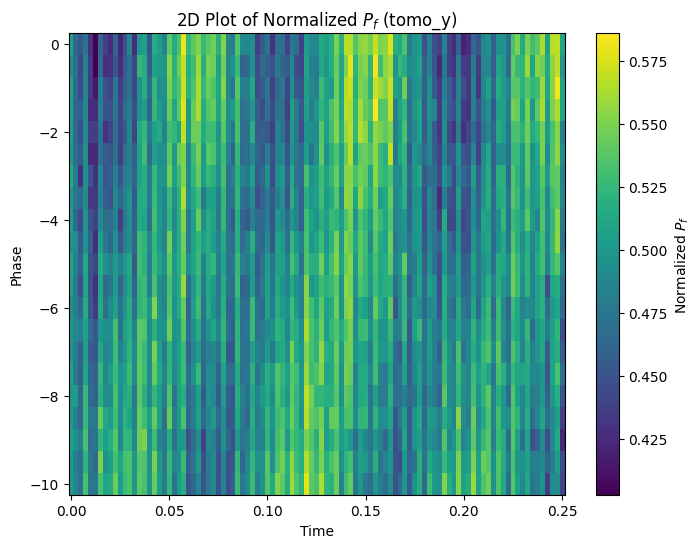

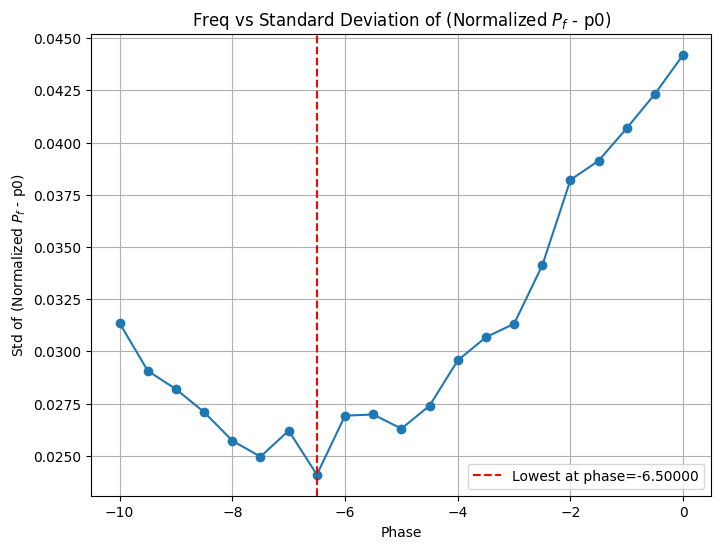

Amplitude with lowest standard deviation: -6.5


In [15]:
# plot_amp_sweep()
# plot_freq_sweep()
plot_phase_sweep()

Using file: sweep_y_tomo\phase_sweep\amp=-6.50000.pkl (amp ~ -6.50000)


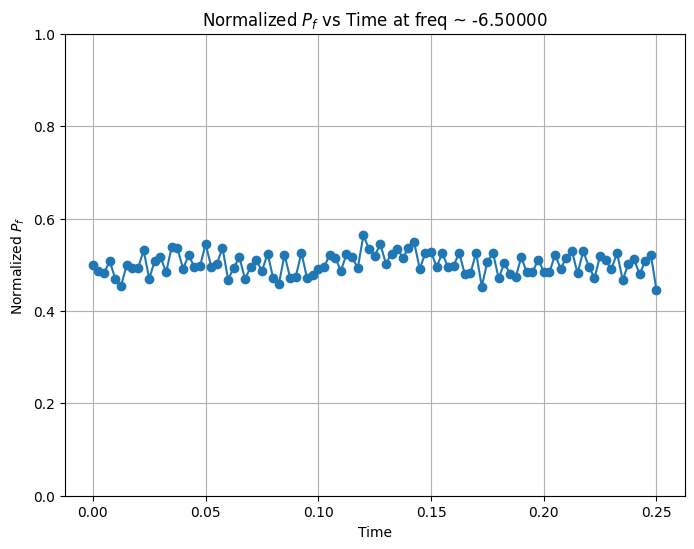

In [16]:
# plot_tomo_y_amp(1.343)
#plot_tomo_y_freq(-.2581)
plot_tomo_y_phase(-6.5)

In [13]:
# # Folder where the tomo_y pickle files are stored
# tomo_y_folder = os.path.join("amp_sweep", "y")


# # Get sorted list of pickle files for tomo_y data
# y_files = sorted(
#     [os.path.join(tomo_y_folder, f) for f in os.listdir(tomo_y_folder) if f.endswith('.pkl')],
#     key=get_amp_from_filename
# )

# amps_y = []
# std_deviation_y = []
# delta_Pf_time_series = []  # To store the time series of (normalized_P_f - p0)
# time_array = None  # Will be taken from the first file (assumed same for all)

# # Loop over each tomo_y file (each amplitude)
# for file in y_files:
#     amp = get_amp_from_filename(file)
#     if amp is None:
#         continue
#     amps_y.append(amp)
    
#     with open(file, "rb") as f:
#         df = pickle.load(f)
    
#     # Get the time axis (assumed identical for all files)
#     if time_array is None:
#         if "time" in df.columns:
#             time_array = df["time"].values
#         else:
#             time_array = df.index.values
    
#     # Compute normalized P_f: P_f_norm = P_f / (P_f + P_e)
#     df["normalized_P_f"] = df["P_f"] / (df["P_f"] + df["P_e"])
    
#     # Compute p0 as the average of max and min of normalized_P_f
#     p0 = (df["normalized_P_f"].max() + df["normalized_P_f"].min()) / 2.0
    
#     # Compute delta = normalized_P_f - p0
#     delta = df["normalized_P_f"] - p0
    
#     # Compute the standard deviation of delta over time
#     std_val = delta.std()
#     std_deviation_y.append(std_val)
    
#     # Save the delta time series for 2D plotting
#     delta_Pf_time_series.append(delta.values)

# # Convert lists to numpy arrays
# amps_y = np.array(amps_y)
# std_deviation_y = np.array(std_deviation_y)
# delta_Pf_array = np.array(delta_Pf_time_series)  # Shape: [n_amp, n_time]

# # Sort by amplitude for plotting consistency
# sort_idx = np.argsort(amps_y)
# amps_y_sorted = amps_y[sort_idx]
# std_deviation_y_sorted = std_deviation_y[sort_idx]
# delta_Pf_array_sorted = delta_Pf_array[sort_idx, :]



# # ------------------
# # Plot: Amp vs Standard Deviation of (Normalized_P_f - p0)
# plt.figure(figsize=(8,6))
# plt.plot(amps_y_sorted, std_deviation_y_sorted, marker='o', linestyle='-')
# plt.xlabel('Amp')
# plt.ylabel('Std of (Normalized $P_f$ - p0)')
# plt.title('Amp vs Standard Deviation of (Normalized $P_f$ - p0)')
# plt.grid(True)

# # Find the amplitude with the lowest standard deviation (lowest peak)
# min_idx = np.argmin(std_deviation_y_sorted)
# best_amp = amps_y_sorted[min_idx]
# plt.axvline(best_amp, color='red', linestyle='--', label=f'Lowest at amp={best_amp:.5f}')
# plt.legend()
# plt.show()

# print("Amplitude with lowest standard deviation:", best_amp)


In [14]:
# def run_phase_measurements():
#     reps = 5000
#     sweep_time = 250
#     swap_freq = -0.0194
#     swap_time = 0.5 * 7 / abs(swap_freq)
#     #mixer_offset_ef=23
#     mixer_offset_ge=18
#     num_steps = 51
#     sweep_start=-15
#     sweep_end=25
#     sweep_steps=21
#     sweep_vals = np.linspace(sweep_start, sweep_end, sweep_steps)

#     # Define folders for plus and minus data (adjust folder names as needed)
    
#     tomo_y_folder = os.path.join("phase_sweep", "y")
    
#     os.makedirs(tomo_y_folder, exist_ok=True)
#     # Dictionaries to store the loaded or computed data
#        # For tomography "x" measurements
#     return_y = {}   # For tomography "y" measurements


#     # Loop over sweep values (e.g., different phase values)
#     for i, sweep_val in enumerate(sweep_vals):
#         # Build filenames using the sweep value as part of the name
        
#         y_filename = os.path.join(tomo_y_folder, f"phase={sweep_val:.5f}.pkl")
        
#         # If both files exist, load them and store in the dictionaries
#         if  os.path.exists(y_filename):
#             with open(y_filename, "rb") as f:
#                 y_data = pickle.load(f)
#             return_y[sweep_val] = y_data
#             continue  # Skip to the next sweep value if files exist
        
#         # Otherwise, perform the measurement:
#         # In your case, y_ph is set by sweep_val
#         mixer_offset_ef=sweep_val
#         #mixer_offset_ge=sweep_val
#         tomography_x = "x"
#         tomography_y = "y"
        
#         df_prob_y, df_pop_y, values_y = run_rabi_tomo(
#             q1=q1,
#             q2=q2,
#             general_vals_dict=general_vals_dict,
#             num_steps=num_steps,
#             sweep_time=sweep_time,
#             swap_freq=swap_freq,
#             swap_time=swap_time,
#             reps=reps,
#             tomography=tomography_y,
#             mixer_offset_ge=mixer_offset_ge,
#             mixer_offset_ef=mixer_offset_ef,   
#         )
        
#         # Save the measurement results to their respective pickle files
        
#         with open(y_filename, "wb") as f:
#             pickle.dump(df_prob_y, f)
        
#         # Populate the dictionaries with the results, keyed by the sweep value
#         return_y[sweep_val] = df_prob_y

#     print("Measurement complete!")
#     return  return_y